# LDO segmentation development 

In [98]:
import os
from glob import glob
from skimage import io
import napari
import btrack
import stardist
import cellpose
from tqdm.auto import tqdm

# Define image filename (fn) as a string

I have first defined a `root_dir` (i.e. an folder address where the images are kept) and then joined (using `os.path.join`) that with the image basename (i.e. the actual filename of just the image) so that it's easier to read the final identifying part of the whole full image path. 
The `root_dir` string will look different on a Mac as the way our respective computers connect to NEMO is different. 

In [2]:
root_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/images'

In [3]:
# folder where the images are kept
root_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_LDO_MTB/images'
# now define the image file name
image_file_name = '20230802_20X_23-03-001A2_DAPI_ZO-1_LDO_Mtb_Multichannel Z-Stack_20230802_1504.tif'
image_path = os.path.join(root_dir, image_file_name)
print(f'Loading image path: {image_file_name}')
image = io.imread(image_path)
print(f'Loaded image: {image_file_name}')

Loading image path: 20230802_20X_23-03-001A2_DAPI_ZO-1_LDO_Mtb_Multichannel Z-Stack_20230802_1504.tif
Loaded image: 20230802_20X_23-03-001A2_DAPI_ZO-1_LDO_Mtb_Multichannel Z-Stack_20230802_1504.tif


# Launch napari with image

In [5]:
# this opens the napari viewer
viewer = napari.Viewer(title = os.path.basename(image_path))
# and this adds the image and organises it as the channels are on the final axis (nota)
viewer.add_image(image, channel_axis=-1)

[<Image layer 'Image' at 0x7fad7389f790>,
 <Image layer 'Image [1]' at 0x7fad68e199a0>,
 <Image layer 'Image [2]' at 0x7fad68e41d00>,
 <Image layer 'Image [3]' at 0x7fad68df5f10>]

### Set example frame

In [9]:
image.shape

(81, 2304, 2304, 4)

In [12]:
frames = image[16,...]

In [13]:
frames.shape

(2304, 2304, 4)

In [14]:
frames_crop = frames[737:1370, 873:1570, ...]

In [15]:
viewer.add_image(frames_crop, channel_axis = -1)

[<Image layer 'Image [4]' at 0x7fabc346feb0>,
 <Image layer 'Image [5]' at 0x7fabc3472910>,
 <Image layer 'Image [6]' at 0x7fabc33aed30>,
 <Image layer 'Image [7]' at 0x7fabc2792f40>]

In [16]:
dapi_crop = frames_crop[..., 0]

In [17]:
viewer.add_image(dapi_crop,)#channel_axis = -1)

<Image layer 'dapi_crop' at 0x7fabc20158e0>

In [51]:
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
import matplotlib.pyplot as plt
import numpy as np
lbl_cmap = random_label_cmap()

In [29]:
from csbdeep.utils import normalize
axis_norm = (0,1) 

In [30]:
norm = normalize(dapi_crop, 1, 99.8, axis=axis_norm)

In [33]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [37]:
img = norm

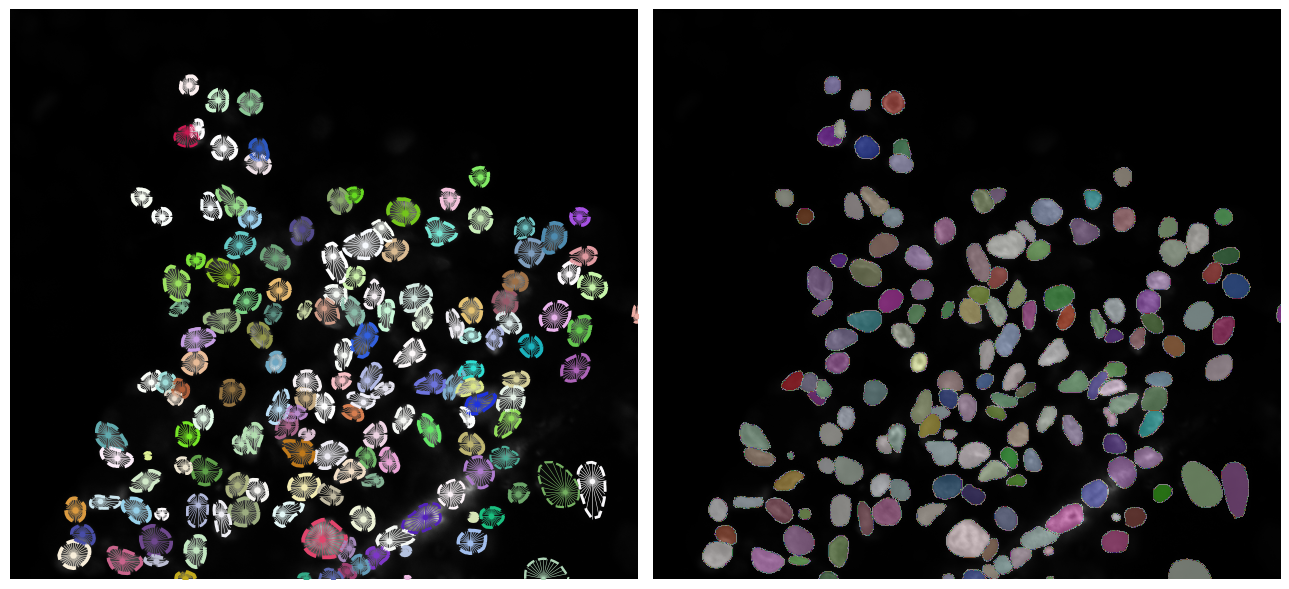

In [158]:

nuc_labels, details = model.predict_instances(img)

plt.figure(figsize=(13,10))
img_show = img if img.ndim==2 else img[...,0]
coord, points, prob = details['coord'], details['points'], details['prob']
plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
a = plt.axis()
_draw_polygons(coord, points, prob, show_dist=True)
plt.axis(a)
plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
plt.imshow(nuc_labels, cmap=lbl_cmap, alpha=0.5)
plt.tight_layout()
plt.show()

In [160]:
viewer.add_labels(nuc_labels)

<Labels layer 'nuc_labels [1]' at 0x7f9e0f1a5a90>

In [43]:
from skimage.measure import regionprops

In [44]:
props = regionprops(labels)

In [58]:
points = np.array([prop.centroid for prop in props])

In [78]:
props[0].p

138.43979951268545

In [79]:
from scipy import spatial
from scipy.spatial import voronoi_plot_2d

In [59]:
triangulation = spatial.Delaunay(points, furthest_site=False, incremental=False, qhull_options=None)

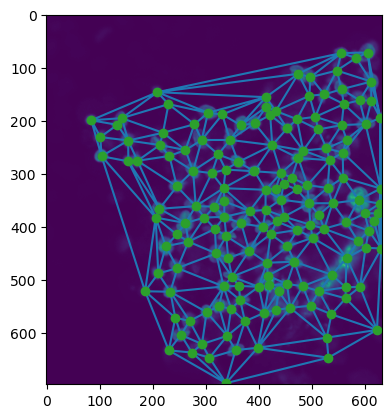

In [64]:
test = plt.triplot(points[:,0], points[:,1], triangulation.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.imshow(dapi_crop.T)
plt.show()

In [150]:
voronoi = spatial.Voronoi(points, qhull_options='Qz')

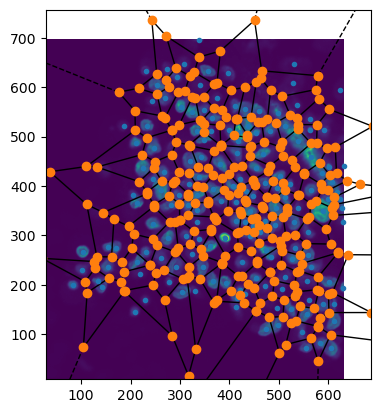

<Figure size 1600x1600 with 0 Axes>

In [151]:
fig = voronoi_plot_2d(voronoi)

plt.imshow(dapi_crop.T)
plt.figure(figsize=(16,16))
plt.show()

In [152]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[0:dapi_crop.shape[0], 0:dapi_crop.shape[1]]

labels = griddata(points, np.arange(len(points)), (grid_x, grid_y), method='nearest')

In [156]:
viewer.add_points(voronoi.vertices)

<Points layer 'Points' at 0x7f9e0abf4340>

In [161]:
viewer.add_labels(labels)

<Labels layer 'labels' at 0x7f9e0f920f40>

In [154]:
labels

array([[ 36,  36,  36, ...,  52,  52,  52],
       [ 36,  36,  36, ...,  52,  52,  52],
       [ 36,  36,  36, ...,  52,  52,  52],
       ...,
       [ 33,  33,  33, ..., 149, 149, 149],
       [ 33,  33,  33, ..., 149, 149, 149],
       [ 33,  33,  33, ..., 149, 149, 149]])

### Perinuclear labels

In [162]:
import cv2

In [166]:
nuc_labels.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [170]:
from skimage import segmentation

In [174]:
expand_nuc_labels = segmentation.expand_labels(nuc_labels, distance=20)
viewer.add_labels(expand_nuc_labels)

<Labels layer 'expand_nuc_labels [2]' at 0x7fab85134880>

# Expanding that across all Mphi nuclei

In [183]:
viewer.layers['Shapes'].data

[array([[  16.        ,  786.27746635,  990.0826734 ],
        [  16.        ,  805.37930985,  964.61354873],
        [  16.        ,  829.25661422,  940.73624436],
        [  16.        ,  848.35845772,  920.04258057],
        [  16.        ,  877.01122296,  899.34891678],
        [  16.        ,  921.58219112,  883.43071387],
        [  16.        ,  964.56133899,  870.69615154],
        [  16.        , 1061.66237677,  861.14522979],
        [  16.        , 1163.53887542,  862.73705008],
        [  16.        , 1241.5380697 ,  870.69615154],
        [  16.        , 1321.12908427,  892.98163562],
        [  16.        , 1376.84279447,  910.49165882],
        [  16.        , 1418.23012205,  937.55260378],
        [  16.        , 1426.1892235 , 1029.87818068],
        [  16.        , 1418.23012205, 1138.1219605 ],
        [  16.        , 1395.94463797, 1259.10030265],
        [  16.        , 1333.8636466 , 1375.30318392],
        [  16.        , 1206.51802329, 1504.24062753],
        [ 

In [187]:
dapi = image[...,0]

In [188]:
dapi.shape

(81, 2304, 2304)

In [193]:
dapi_frame = dapi[16]

In [197]:
coords = viewer.layers['Shapes'].data[0][:, -2:]

In [201]:
import numpy as np
from skimage.draw import polygon

def mask_image_outside_polygon(image, perimeter_coords):
    # Create an empty binary mask with zeros
    mask = np.zeros(image.shape[:2], dtype=bool)

    # Get the row and column indices of the points within the polygon
    rr, cc = polygon(np.array([p[0] for p in perimeter_coords]), np.array([p[1] for p in perimeter_coords]), mask.shape)

    # Set the values inside the polygon to True
    mask[rr, cc] = True

    # Apply the mask to the input image
    masked_image = image.copy()
    masked_image[~mask] = 0

    return masked_image

In [212]:
masked_image = np.zeros_like(dapi)
masked_mask = np.zeros_like(dapi)
expanded_masked_mask = np.zeros_like(dapi)
for n, frame in tqdm(enumerate(dapi), total = len(dapi)):
    masked_frame = mask_image_outside_polygon(frame, coords)
    masked_image[n] = masked_frame
    masked_frame = normalize(masked_frame, 1, 99.8, axis=axis_norm)
    nuc_labels, details = model.predict_instances(masked_frame)
    masked_mask[n] = nuc_labels
    expand_nuc_labels = segmentation.expand_labels(nuc_labels, distance=20)
    expanded_masked_mask[n] = expand_nuc_labels

  0%|          | 0/81 [00:00<?, ?it/s]

In [213]:
viewer.add_image(masked_image)
viewer.add_labels(masked_mask)

<Labels layer 'masked_mask [1]' at 0x7fab85109d90>

In [214]:
viewer.add_labels(expanded_masked_mask)

<Labels layer 'expanded_masked_mask' at 0x7f9cbc193d30>

In [211]:
print()